# Get modflow 6 water budget components from the .lst file

In [65]:
from flopy import mf6, utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

## Functions

In [108]:
def plot(x: [], x_label: str, y: [], y_label: str, title: str,
         fig_path: Path = None, display: bool = True,
         xlength: float=8, ylength: float=6, as_bar: bool=True):
    """
    xlength, ylength in inches
    """

    plt.rcParams["figure.figsize"] = (xlength, ylength)
    
    fig, ax = plt.subplots()
    if as_bar:
        ax.bar(x, y, color='blue')    
    else:
        ax.plot(x, y, color='blue')

    # Set aspect ratio and labels
#    ax.set_aspect('equal')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

    plt.grid(True)

    if display:
        plt.show()
    else:
        plt.savefig(fig_path)
        plt.clf()
    plt.rcParams.update(plt.rcParamsDefault)


def replace_elements(element, dic1, dic2):
    for key, value in dic1.items():
        if key in element:
            element = element.replace(key, value)
    for key, value in dic2.items():
        if key in element:
            element = element.replace(key, value)
    return element


## Set variables

In [46]:
# Modflow: file and directory names
model_name = 'ex01.nam'
model_path = r'E:\EDU\GroundWater\mf6_exercises\ex01'
model_path = Path(model_path)

# Model units
length_unit = 'm'
time_unit = 'day'

# lst file set in base of model_name
lst_path = model_path.joinpath(model_name)
lst_path = lst_path.with_suffix('.lst')
print(lst_path)

E:\EDU\GroundWater\mf6_exercises\ex01\ex01.lst


## Read the model

In [15]:
# gwf is instantiated and some basic features are shown
sim = mf6.MFSimulation.load(sim_name=modelname, exe_name='mf6', sim_ws=model_path,verbosity_level=0)

model_names = list(sim.model_names)
print('\nModel names in sim', model_names)

model = sim.get_model(model_names[0])

# general information of my model
package_list = model.get_package_list()
print('Packages:', package_list)
print('Number of layers:', model.dis.nlay.array)  # Number of layers
print('Number of cells:', model.dis.ncpl.array)  # Number of cells per layer
print('Number of active cells:',(model.dis.idomain.array > 0).sum())
grid_type = model.modelgrid.grid_type
print('Type of grid:', grid_type)

tdis = sim.tdis
nper = tdis.nper.get_data()
print('Number of stress periods:', nper)  

print("Model object: ", model.output.methods())


Model names in sim ['modflow']
Packages: ['DISV', 'IC', 'NPF', 'OBS-1', 'STO', 'OC', 'WEL-1', 'DRN-1', 'RCH-1']
Number of layers: 1
Number of cells: 1250
Number of active cells: 1250
Type of grid: vertex
Number of stress periods: 13
Model object:  ['list()', 'zonebudget()', 'budget()', 'budgetcsv()', 'head()']


## Read the components of the water budget in the .lst file

In [62]:
# create an instance of Mf6ListBudget
budget_obj = utils.Mf6ListBudget(lst_path)

data = budget_obj.get_budget()
dtype = data[0].dtype
dtype_names = dtype.names
list_of_dicts = [dict(zip(dtype_names, row.tolist())) for row in data[0]]
df = pd.DataFrame(list_of_dicts)

print('Water budget dataframe')
df.head()

Water budget dataframe


,totim,time_step,stress_period,STO-SS_IN,WEL_IN,DRN_IN,RCH_IN,TOTAL_IN,STO-SS_OUT,WEL_OUT,DRN_OUT,RCH_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY,tslen
0,1.0,0,0,0.000000,0.0,0.0,10000.000000,10000.000000,0.000000e+00,0.000000,10000.043945,0.0,10000.043945,-0.044335,-0.0,1.0000
1,32.0,15,1,9741.979492,0.0,0.0,258.064514,10000.043945,2.721800e-05,0.000000,10000.043945,0.0,10000.043945,-0.000009,-0.0,1.9375
2,60.0,22,2,9857.186523,0.0,0.0,142.857101,10000.042969,3.432700e-06,0.000000,10000.043945,0.0,10000.043945,-0.000967,-0.0,4.7382
3,91.0,35,3,10000.042969,0.0,0.0,0.000000,10000.042969,4.118200e-08,0.000000,10000.043945,0.0,10000.043945,-0.001391,-0.0,5.1740
4,121.0,14,4,10033.374023,0.0,0.0,0.000000,10033.374023,0.000000e+00,33.333302,10000.041016,0.0,10033.374023,-0.000008,-0.0,2.0000


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   totim                13 non-null     float64
 1   time_step            13 non-null     int64  
 2   stress_period        13 non-null     int64  
 3   STO-SS_IN            13 non-null     float64
 4   WEL_IN               13 non-null     float64
 5   DRN_IN               13 non-null     float64
 6   RCH_IN               13 non-null     float64
 7   TOTAL_IN             13 non-null     float64
 8   STO-SS_OUT           13 non-null     float64
 9   WEL_OUT              13 non-null     float64
 10  DRN_OUT              13 non-null     float64
 11  RCH_OUT              13 non-null     float64
 12  TOTAL_OUT            13 non-null     float64
 13  IN-OUT               13 non-null     float64
 14  PERCENT_DISCREPANCY  13 non-null     float64
 15  tslen                13 non-null     float

In [103]:
# translation names used in plots (add more if needed)
dic1 = {'STO-SS': 'Storage - Specific Storage',
        'WEL': 'Wells',
        'DRN': 'Drains',
        'RCH': 'Recharge',
        'TOTAL': 'Total',
        'IN-OUT': 'Input - Output',
        'PERCENT_DISCREPANCY': 'Percent Discrepancy',
        'tslen': 'Time Step Length'
       }
dic2 = {'_IN': '(input)', '_OUT': '(output)'}


## Plot water budgets components in the screen
You can plot components as a scatter plot with lines or as a bar plot using as_bar parameter

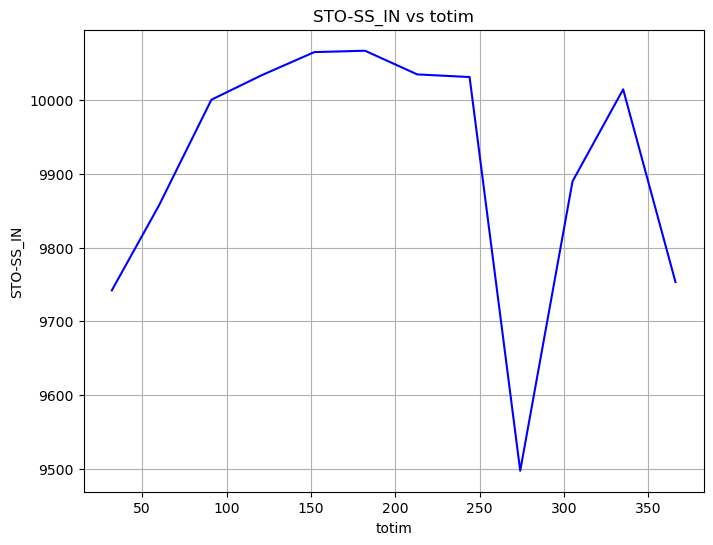

In [110]:
xc = 'totim'
yc = 'STO-SS_IN'

plot(df[xc][1:], xc, df[yc][1:], yc, f'{yc} vs {xc}', as_bar=False)

## Save the plots of the water budget components to files
All in a row<br>
The size of the figure can be set (units inches)<br>
Look into function definition to the complete list of parameters

In [109]:
# directory path where figures will be saved
dir_path = r'E:\EDU\GroundWater\mf6_exercises\ex01\xybudget'
dir_path = Path(dir_path)

col_names = df.columns.tolist()
xc = 'totim' 
xlabel = f'time ({time_unit})'
for i, cn1 in enumerate(col_names[3:]):
    long_name = replace_elements(cn1, dic1, dic2)
    title = f'{long_name} vs. time'
    fig_path = dir_path.joinpath(f'{i:02d}_{cn1}.png')
    ylabel = f'{long_name} ({length_unit}^3)'
    plot(df[xc][1:], xlabel, df[cn1][1:], ylabel, title, fig_path, False, 7, 4)


<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>